# Generate a Noise Model using Calibration Data 

We will use pairs of noisy calibration observations $x_i$ and clean signal $s_i$ (created by averaging these noisy, calibration images) to estimate the conditional distribution $p(x_i|s_i)$. Histogram-based and Gaussian Mixture Model-based noise models are generated and saved. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0") 
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys

from ppn2v.pn2v import *
import ppn2v.pn2v.gaussianMixtureNoiseModel
import ppn2v.pn2v.histNoiseModel
from ppn2v.pn2v.utils import *

### Download data

Download the data from https://zenodo.org/record/5156960/files/Mouse%20skull%20nuclei.zip?download=1. Here we show the pipeline for Mouse skull nuclei dataset. Load the appropriate dataset at an appropriate path. For us, the path is data folder which exists at `../../../`. For Mouse skull nuclei, the data to be denoised is named ```example2_digital_offset300.tif```. 

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data/Mouse skull nuclei'):
    os.mkdir('../../../data/Mouse skull nuclei')

zipPath="../../../data/Mouse_skull_nuclei.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve(' https://zenodo.org/record/5156960/files/Mouse%20skull%20nuclei.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data/Mouse skull nuclei")

The noise model is a characteristic of your camera. The downloaded data folder contains a set of calibration images (For the Mouse skull nuclei dataset, it is ```edgeoftheslide_300offset.tif``` and the data to be denoised is named ```example2_digital_offset300.tif```). We can either bin the noisy - GT pairs (obtained from noisy calibration images) as a 2-D histogram or fit a GMM distribution to obtain a smooth, parametric description of the noise model.

### Specify ```path```, ```dataName```,  ```n_gaussian```, ```n_coeff```
Ensure that ```dataName``` is set same as in ```1_N2VTraining.ipynb```

In [3]:
path="../../../data/Mouse skull nuclei/"
dataName = 'mouseskullnuclei' # Name of the noise model 
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [4]:
observation= imread(path+'edgeoftheslide_300offset.tif') # Load the appropriate data
nameHistNoiseModel ='HistNoiseModel_'+dataName+'_'+'calibration'
nameGMMNoiseModel = 'GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'calibration'

(1, 512, 512)


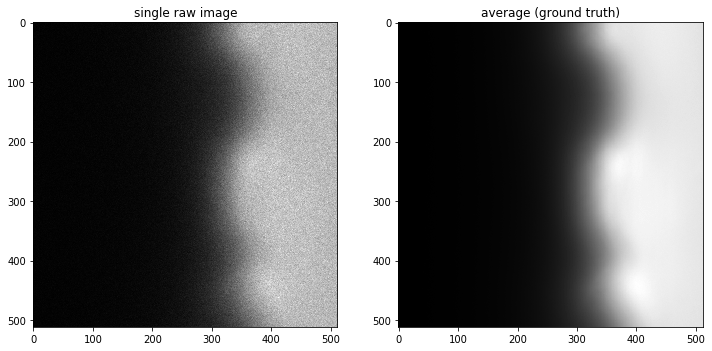

In [5]:
# The data contains 200 images of a static sample.
# In case using calibration data mode, we estimate the clean signal by averaging all images.
signal=np.mean(observation,axis=0)[np.newaxis,...]
    

# Let's look the raw data and our pseudo ground truth signal
print(signal.shape)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.title(label='average (ground truth)')
plt.imshow(signal[0],cmap='gray')
plt.subplot(1, 2, 1)
plt.title(label='single raw image')
plt.imshow(observation[0],cmap='gray')
plt.show()

### Creating the Histogram Noise Model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a histogram based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [6]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
# The dataset is clipped to values between 0 and 255.
minVal, maxVal = 2000, 22000
bins = 400

# We are creating the histogram.
# This can take a minute.
histogram = pn2v.histNoiseModel.createHistogram(bins, minVal, maxVal, observation,signal)

# Saving histogram to disc.
np.save(path+nameHistNoiseModel+'.npy', histogram)
histogramFD=histogram[0]

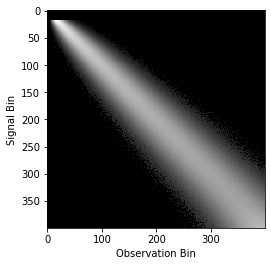

In [7]:
# Let's look at the histogram-based noise model.
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

### Creating the GMM noise model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [8]:
min_signal=np.min(signal)
max_signal=np.max(signal)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Minimum Signal Intensity is 2926.9
Maximum Signal Intensity is 42559.426


Iterating the noise model training for `n_epoch=4000` and `batchSize=25000` works the best for `Mouse Skull Nuclei` dataset. 

In [9]:
gaussianMixtureNoiseModel = pn2v.gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(min_signal = min_signal, max_signal =max_signal, path=path, weight = None, n_gaussian = n_gaussian, n_coeff = n_coeff, min_sigma = 50, device = device)
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 25000, n_epochs = 4000, learning_rate=0.1, name = nameGMMNoiseModel)

0 19.21534538269043
100 8.161229133605957
200 8.14352035522461
300 8.137467384338379
400 8.129465103149414
500 8.13700008392334
600 8.143426895141602
700 8.131543159484863
800 8.12574291229248
900 8.13912582397461
1000 8.136778831481934
1100 8.14112377166748
1200 8.129722595214844
1300 8.131614685058594
1400 8.13129997253418
1500 8.128573417663574
1600 8.135686874389648
1700 8.13410758972168
1800 8.124873161315918
1900 8.133441925048828
2000 8.128556251525879
2100 8.125373840332031
2200 8.134140968322754
2300 8.133405685424805
2400 8.130763053894043
2500 8.148366928100586
2600 8.128501892089844
2700 8.124931335449219
2800 8.119243621826172
2900 8.134356498718262
3000 8.137941360473633
3100 8.145896911621094
3200 8.12974739074707
3300 8.125048637390137
3400 8.139037132263184
3500 8.132753372192383
3600 8.129409790039062
3700 8.124893188476562
3800 8.133451461791992
3900 8.14606761932373

The trained parameters (GMMNoiseModel_mouseskullnuclei_3_2_calibration) is saved at location: ../../

### Visualizing the Histogram-based and GMM-based noise models

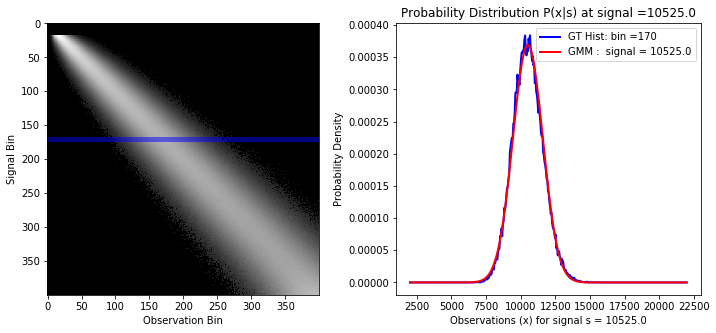

In [10]:
plotProbabilityDistribution(signalBinIndex=170, histogram=histogramFD, gaussianMixtureNoiseModel=gaussianMixtureNoiseModel, min_signal=minVal, max_signal=maxVal, n_bin= bins, device=device)